In [2]:
### importieren
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.datasets.samples_generator import make_blobs #random data generator
import pandas as pd



In [3]:
# Read dataset
df = pd.read_csv('Pokemon.csv', index_col=0, engine='python')
df.head()


,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [151]:
from sklearn.cluster import KMeans
X = df.values
x1 = X[:,5:7]
x1

array([[49, 49],
       [62, 63],
       [82, 83],
       ...,
       [110, 60],
       [160, 60],
       [110, 120]], dtype=object)

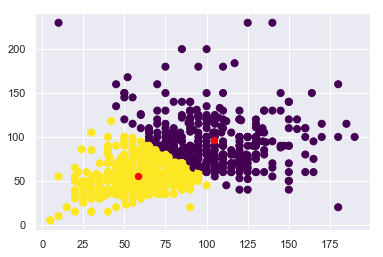

In [152]:
X = df.values
x = X[:,5:7]

kmeans = KMeans(n_clusters=2, init='random')
kmeans.fit(x)
y_kmeans = kmeans.predict(x)

plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=40, alpha=1);

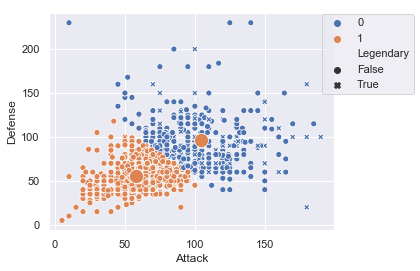

In [153]:
g = sns.scatterplot(x= df.Attack, y= df.Defense, hue= y_kmeans, style=df.Legendary, legend= "brief")
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], palette="flatui", s=200)

box = g.get_position()
g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
g.legend(loc='lower right', bbox_to_anchor=(1.3, 0.6))

plt.show()

In [154]:
a=0
for idx in range (len(y_kmeans)):
    if y_kmeans[idx]==0 and X[idx,11]==True:
        a+=1
a

64

In [155]:
a=0
for idx in range (len(y_kmeans)):
    if y_kmeans[idx]==1 and X[idx,11]==True:
        a+=1
a

1

In [156]:
for idx in range (len(y_kmeans)):
    if y_kmeans[idx]==1 and X[idx,11]==True:
        print (X[idx])

['Regice' 'Ice' nan 580 80 50 100 100 200 50 3 True]


In [180]:
#Ab hier beginnt unser code
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import numba
from numba import njit, jit
from statistics import mean
from sklearn.datasets.samples_generator import make_blobs
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin

class Kmeans(BaseEstimator, ClusterMixin, TransformerMixin):               # Input: processed dataset, Output: clustered data (kmeans, kmeans++)
    def __init__(self, inits=10, k=8, maxit=300, method="++", tol = 1e-3):
        
        self.labels_ = None
        self.cluster_centers_ = None
        self._inits = inits
        self._k = k
        self._maxit = maxit
        self._method = method
        self._tol = tol
       # dot = np.random.choice(range(len(self._data)), self._k, replace=False)
        #self._clusters = self._data[dot]
   

    def fit(self,data):
        self._data = data
        best_clust = float('inf')
        
        for i in (range(self._inits)):
            
            if self._method == "rng": # random centers are choosen
                #print("rng")
                dot = np.random.choice(range(len(self._data)), self._k, replace=False)
                self.cluster_centers_ = self._data[dot]
            elif self._method == "++": # kmeans++ is initiated
                #print("++")
                dot = np.random.choice(len(self._data), replace=False) # random startpunkt
                clusters = np.array([self._data[dot]])
                pointer = np.array([])
                for i in range (self._k-1):
                    D = np.array([])
            
                    for j in range (len(self._data)):
                        D = np.append(D,np.min(np.sum((self._data[j]-clusters)**2, axis = 1)))
                
                    pointer = np.append(pointer, D, axis = 0) 
            
                    p = D/np.sum(D)
                    cummulative_p = np.cumsum(p)
            
                    r = random.random()
                    ind = np.where(cummulative_p >= r)[0][0]
            
                    clusters = np.append(clusters,[self._data[ind]], axis = 0)
                self.cluster_centers_ = clusters
            else:
                raise AttributeError("No valid method")

            old_centroids = None
            
            for i in range(self._maxit):
                old_centroids = self.cluster_centers_.copy()
                clusters = np.expand_dims(self.cluster_centers_, axis=1)
                data = np.expand_dims(self._data, axis=0)
                eucl = np.linalg.norm(clusters-data, axis=2) # euclidean dist by using integrated numpy function
                self.labels_ = np.argmin(eucl, axis = 0)
                for i in range(self._k): # range of clusters
                    position = np.where(self.labels_ == i) # position im array bestimmen und dann die entspechenden punkte aus data auslesen
                    self.cluster_centers_[i] = self._data[position].mean(axis = 0)
                    #out = pd.DataFrame(data[np.argwhere(dist == i)].squeeze())
                overall_quality = np.sum(np.min(eucl.T, axis=1))
                if overall_quality < best_clust:
                    best_clust = overall_quality
                    best_dist = self.labels_
                    best_centers = self.cluster_centers_
                if np.linalg.norm(best_centers - old_centroids) < self._tol:
                    break
            self.cluster_centers_ = best_centers
            self.labels_ = best_dist
                
        return self
   
    
    def predict(self, X):
        clusters = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(X, axis=0)
        eucl = np.linalg.norm(clusters-data, axis=2) # euclidean dist by using integrated numpy function
        self.labels_ = np.argmin(eucl, axis = 0)
        return self.labels_ #returns the cluster with minimum distance
    
    def transform(self, X):
        clusters = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(X, axis=0)
        eucl = np.linalg.norm(clusters-data, axis=2)
        return eucl.T

class MiniBatchKMeans(BaseEstimator, ClusterMixin, TransformerMixin):
    """Performs mini-batch k-means on a set of input data."""
    def __init__(self, k=8, inits=300, max_iterations=300, tol=1e-3, batch_size=128):
        """Simple mini-batch k-means clustering implementation in pure Python.
        
        Args:
            k (int): number of clusters to fit.
            inits (int): number of independent initializations to perform.
            max_iterations (int): maximum number of iterations to perform.
            tol (float): tolerance for early stopping.
            batch_size (int): number of datapoints for the minibatch.
        """
        self.labels_ = None
        self.cluster_centers_ = None
        self._k = k
        self._inits = inits
        self._max_iterations = max_iterations
        self._tol = tol
        self._batch_size = batch_size
        
    def create_batch(self, data): 
        data_batch = np.random.choice(range(len(data)), self._batch_size, replace=False)
        return data[data_batch]
        
        """chooses x (x = batch_size) random points from the data to create the data batch
        """
        
    def initialize(self, data): 
        indices = np.random.choice(range(len(data)), self._k, replace=False)
        return data[indices], np.zeros(self._k)
        
        """chooses k random data points from data, to set centers for clustering
        """
    
    def expectation(self, data, centroids): 
        centroids = np.expand_dims(centroids, axis=1)
        data = np.expand_dims(data, axis=0)
        metric = np.linalg.norm(centroids - data, axis=2)
        return np.argmin(metric, axis=0)
        
        """measures the euclidean distance between each data_batch points and center points using numpys linalg.norm function
        """
    
    @staticmethod
    @numba.jit(nopython=True)
    def _maximization_aux(data, assignments, centroids, centroid_count): #verschiebt die centroids richtung clustermittelpunkt mit lr
        update = centroids.copy()
        for idx, assignment in enumerate(assignments):
            data_point = data[idx]
            centroid_count[assignment] += 1
            lr = 1 / centroid_count[assignment] #learning rate
            update[assignment] = update[assignment] * (1 - lr) + data_point * lr
        return update
    
        """Moves the centroids to the new centroid point of the assigned data_batch points. But not completely, but according to the learning rate
        """
    
    def maximization(self, data, assignments, centroids, centroid_count): 
        return MiniBatchKMeans._maximization_aux(data, assignments, centroids, centroid_count)
    
        """This part applies maximization_aux on the data using maximization_aux
        """
    
    def final_assignments(self, data, centroids): 
        assignments = []
        for idx in range(len(data) // self._batch_size + 1):
            start = idx * self._batch_size
            stop = min(idx * self._batch_size + self._batch_size, len(data))
            sub_result = self.expectation(data[start:stop], centroids)
            assignments.append(sub_result)
        return np.concatenate(assignments, axis=0)
    
        """Assignes the rest of the data points to the centroids, which were determined before (not only batch_points)
        """
    
    def fit(self, data): #alles zusammen
        centroids, counts = self.initialize(data)
        
        old_centroids = None
        for idx in range(self._max_iterations):
            old_centroids = centroids.copy()
            
            batch = self.create_batch(data)
            assignments = self.expectation(batch, centroids)
            centroids = self.maximization(batch, assignments, centroids, counts)
            
            if np.linalg.norm(centroids - old_centroids) < self._tol:
                break

        self.labels_ = self.final_assignments(data, centroids)
        self.cluster_centers_ = centroids
                
        return self
    
    def predict(self, data):
        
        centroids = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(data, axis=0)
        metric = np.linalg.norm(centroids - data, axis=2)
        self.labels_ = np.argmin(metric, axis=0)
        
        return self.labels_

    
    def transform(self, data):
        
        centroids = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(data, axis=0)
        metric = np.linalg.norm(centroids - data, axis=2)
        
        return metric.T



In [185]:
x = np.array(list(x), dtype=np.float)

In [186]:
x

array([[ 49.,  49.],
       [ 62.,  63.],
       [ 82.,  83.],
       ...,
       [110.,  60.],
       [160.,  60.],
       [110., 120.]])

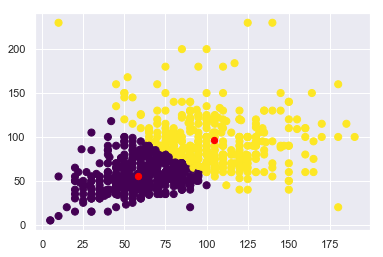

In [188]:
#unser code im vanilla/ random modus
kmeans = Kmeans(k=2, method='rng')
kmeans.fit(x)
y_kmeans = kmeans.predict(x)

plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=40, alpha=1);

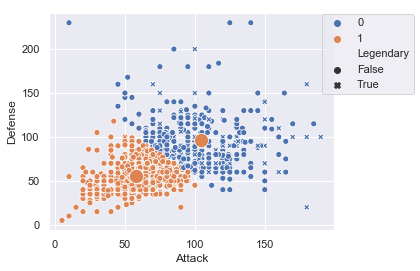

In [201]:
#unser code im vanilla/ random modus, in schön
g = sns.scatterplot(x= df.Attack, y= df.Defense, hue= y_kmeans, style=df.Legendary, legend= "brief")
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], palette="flatui", s=200)

box = g.get_position()
g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
g.legend(loc='lower right', bbox_to_anchor=(1.3, 0.6))

plt.show()

In [202]:
a=0
b=0
for idx in range (len(y_kmeans)):
    if y_kmeans[idx]==0 and X[idx,11]==True:
        a+=1
    if y_kmeans[idx]==1 and X[idx,11]==True:
            b+=1
print ("Legendaries in cluster 0 (blue): " ,a)
print ("Legendaries in cluster 1 (orange): " ,b)

Legendaries in cluster 0 (blue):  64
Legendaries in cluster 1 (orange):  1


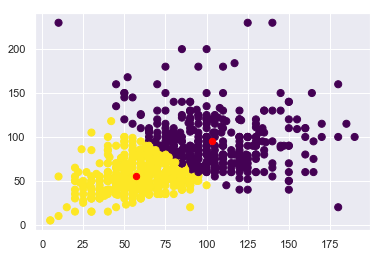

In [196]:
#unsere Minibatch implementierung
kmeans = MiniBatchKMeans(k=2)
kmeans.fit(x)
y_kmeans = kmeans.predict(x)

plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=40, alpha=1);

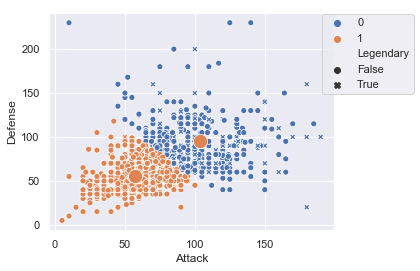

Legendaries in cluster 0 (blue):  64
Legendaries in cluster 1 (orange):  1


In [197]:
#unsere mbkmeans geplottet
g = sns.scatterplot(x= df.Attack, y= df.Defense, hue= y_kmeans, style=df.Legendary, legend= "brief")
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], palette="flatui", s=200)

box = g.get_position()
g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
g.legend(loc='lower right', bbox_to_anchor=(1.3, 0.6))

plt.show()

a=0
b=0
for idx in range (len(y_kmeans)):
    if y_kmeans[idx]==0 and X[idx,11]==True:
        a+=1
    if y_kmeans[idx]==1 and X[idx,11]==True:
            b+=1
print ("Legendaries in cluster 0 (blue): " ,a)
print ("Legendaries in cluster 1 (orange): " ,b)

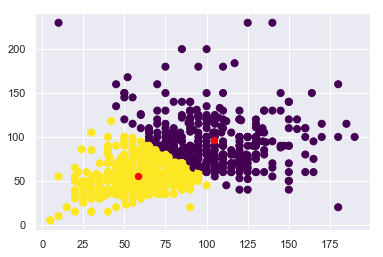

In [199]:
#und noch unsere ++
kmeans = Kmeans(k=2, method='++')
kmeans.fit(x)
y_kmeans = kmeans.predict(x)

plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=40, alpha=1);


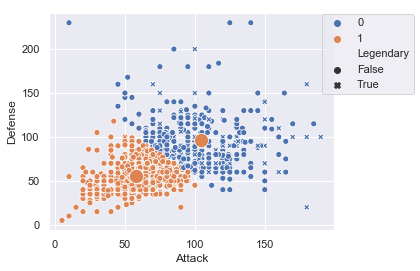

Legendaries in cluster 0 (blue):  64
Legendaries in cluster 1 (orange):  1


In [200]:
#unser ++ plot
g = sns.scatterplot(x= df.Attack, y= df.Defense, hue= y_kmeans, style=df.Legendary, legend= "brief")
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], palette="flatui", s=200)

box = g.get_position()
g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
g.legend(loc='lower right', bbox_to_anchor=(1.3, 0.6))

plt.show()

a=0
b=0
for idx in range (len(y_kmeans)):
    if y_kmeans[idx]==0 and X[idx,11]==True:
        a+=1
    if y_kmeans[idx]==1 and X[idx,11]==True:
            b+=1
print ("Legendaries in cluster 0 (blue): " ,a)
print ("Legendaries in cluster 1 (orange): " ,b)